In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold


import matplotlib.pyplot as plt



In [68]:
data = pd.read_csv("out/data.csv")

data = data.drop(columns=["cases.submitter_id"])

# Step 3: Initial exploration
print("Initial data shape:", data.shape)
print(data.head())
print(data.info())
print(data['OS'].value_counts())


Initial data shape: (658, 20)
             cases.disease_type  demographic.age_at_index  \
0  Adenomas and Adenocarcinomas                      81.0   
1  Adenomas and Adenocarcinomas                      67.0   
2  Adenomas and Adenocarcinomas                      79.0   
3  Adenomas and Adenocarcinomas                      70.0   
4  Adenomas and Adenocarcinomas                      58.0   

  demographic.country_of_residence_at_enrollment demographic.gender  \
0                                        Germany               male   
1                                        Germany               male   
2                                        Germany             female   
3                                        Germany               male   
4                                        Germany             female   

  diagnoses.ajcc_pathologic_m diagnoses.ajcc_pathologic_n  \
0                          M0                          N2   
1                          M0                         

In [69]:
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].astype(str)



In [70]:
num_cols = data.select_dtypes(include=[np.number]).columns
cat_cols = data.select_dtypes(include=['object']).columns


In [71]:
num_imputer = SimpleImputer(strategy='median')
for col in num_cols:
    if pd.api.types.is_numeric_dtype(data[col]):
        data[col] = data[col].astype(float)
        data[col] = num_imputer.fit_transform(data[[col]])


In [72]:
if len(cat_cols) > 0:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    data[cat_cols] = pd.DataFrame(
        cat_imputer.fit_transform(data[cat_cols]),
        columns=cat_cols,
        index=data.index
    )


In [73]:
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    le_dict[col] = le


In [74]:
X = data.drop('OS', axis=1)
y = data['OS']  # make sure OS is categorical (0/1)

scaler = StandardScaler()
X = scaler.fit_transform(X)

# 3. Create and fit PCA
pca = PCA(n_components=10)  # reduce to 2 dimensions
X = pca.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [75]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [76]:
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [77]:
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.6666666666666666
Classification Report:
               precision    recall  f1-score   support

         0.0       0.59      0.33      0.42        49
         1.0       0.69      0.87      0.77        83

    accuracy                           0.67       132
   macro avg       0.64      0.60      0.59       132
weighted avg       0.65      0.67      0.64       132

Confusion Matrix:
 [[16 33]
 [11 72]]


In [78]:
y_prob = clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC:", roc_auc)


ROC-AUC: 0.6715023358741087


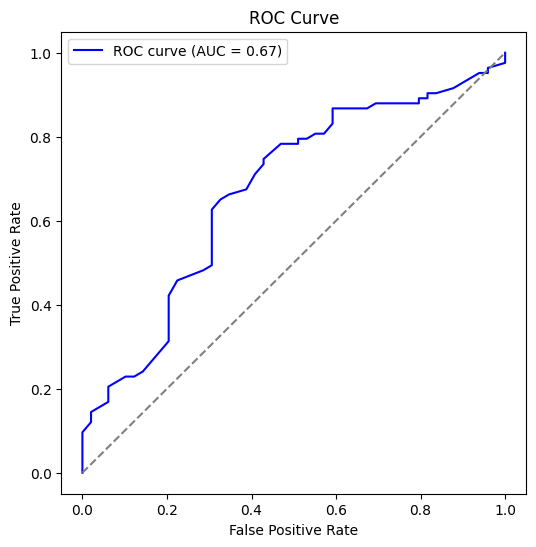

In [79]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
